In [25]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import torch
#from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
#                                       create_network, create_optimizer, create_multiplicative_scheduler)
#from uncertaintylearning.utils.density_estimator import GPVarianceEstimator
#from uncertaintylearning.utils.feature_generator import FeatureGenerator
#from uncertaintylearning.utils.buffer import Buffer
#from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset
from botorch.models import SingleTaskGP
from sklearn.linear_model import LinearRegression
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [26]:
device= torch.device("cpu")
dim=1
def oracle(x, noise=0):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
    return torch.where(torch.logical_and(x > 0.5, x < 1.5),
                       3./5 * (torch.sin(x) * torch.cos(5 * x) * torch.cos(22 * x) * -3 * torch.sin(7 * x) * torch.cos(19 * x) * 4 * torch.sin(11 * x)),
                       (2 * np.pi * x).sin()) + noise * m


In [27]:
def cheat_remove(xx, interval):
    ## xx is a 2 x 1 tensor
    return ood_x[torch.logical_or(ood_x > interval[1], ood_x < interval[0])].unsqueeze(-1)
    

In [28]:
def generate_data(n=1024, nood=32):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0)
        ood_x = torch.zeros(32, 1).uniform_(0.5, 1.5) # it's not really ood x, but just the x s that are in the spiked regions
        x_test = torch.linspace(-0.5, 2.5, 512).view(-1, 1)
        ood_x = torch.zeros(nood // 4, 1).uniform_(-0.25, 0.0)
        ood_x = torch.cat((ood_x, torch.zeros(nood // 4, 1).uniform_(2, 2.25)), 0)
        ood_x = torch.cat((ood_x, torch.zeros(nood, 1).uniform_(0.5, 1.5)), 0)
        y = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, x_test, y_test_true, ood_x, ood_y

x, y, x_test, y_test, ood_x, ood_y = generate_data(100, 24)

# ood_x = cheat_remove(ood_x, (0.65, 0.7))
ood_y = oracle(ood_x)
X_train = x
Y_train = y
#n=100
#X_train = torch.zeros((n, 1)).uniform_(-0.25, 2.25)
#Y_train = oracle(X_train)

In [29]:
ood_x = cheat_remove(ood_x, (0.68, 0.7))
ood_y = oracle(ood_x)

In [30]:
model = SingleTaskGP(X_train, Y_train)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)
predictions = model(x_test)
mean = predictions.mean.detach()
std = predictions.stddev.detach()

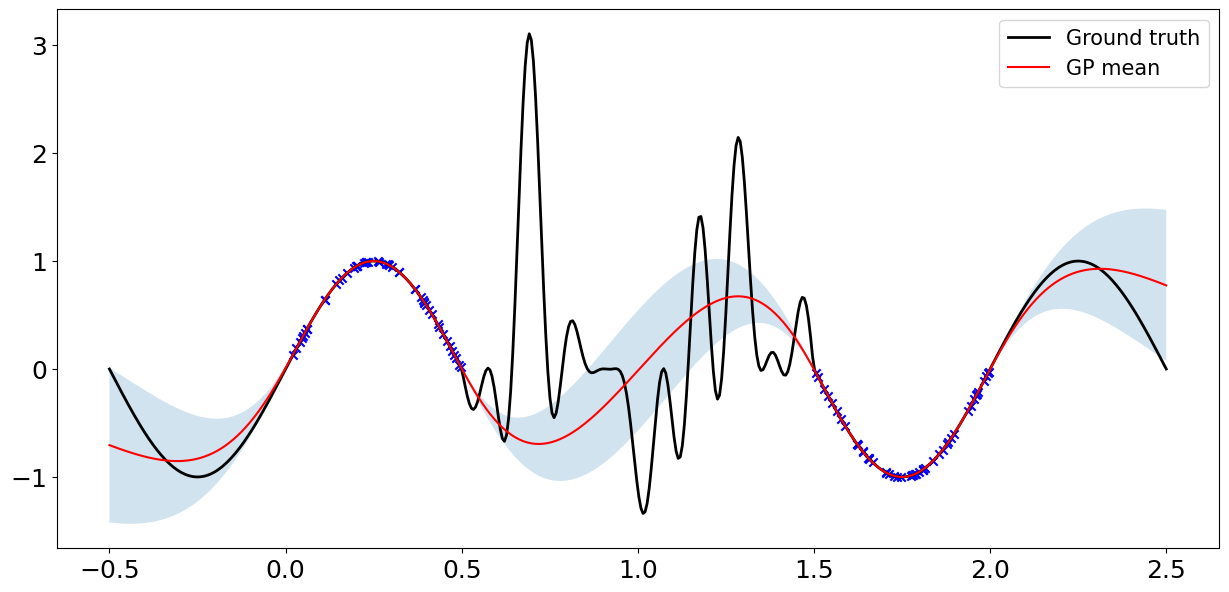

In [31]:
plt.figure(figsize=(15, 7))

plt.plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
plt.plot(x_test, mean, color='r', linewidth=1.5, label='GP mean')
plt.fill_between(x_test.squeeze(), mean - std, mean + std, alpha=.2)
plt.scatter(X_train, Y_train, color='b', marker='x')
plt.legend(prop={'size': 15})
plt.tick_params(axis='both', which='major', labelsize=18)

In [32]:
ood_x = torch.FloatTensor([[0.7], [1.0], [-0.5], [2.5], [1.3]])
ood_y = oracle(ood_x)
X_new = torch.cat((x, ood_x))
Y_new = torch.cat((y, ood_y))
model2 = SingleTaskGP(X_new, Y_new)
mll = ExactMarginalLogLikelihood(model2.likelihood, model2)
_ = fit_gpytorch_model(mll)
predictions2 = model2(x_test)
mean_new = predictions2.mean.detach()
std_new = predictions2.stddev.detach()

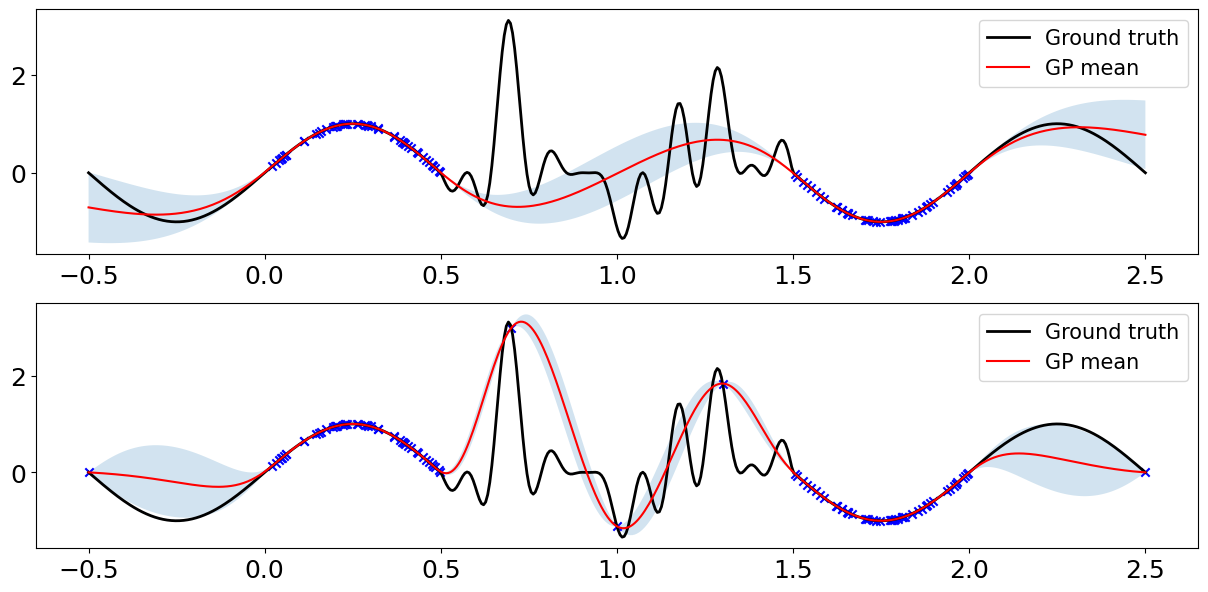

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(15, 7))
axes[0].plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
axes[0].plot(x_test, mean, color='r', linewidth=1.5, label='GP mean')
axes[0].fill_between(x_test.squeeze(), mean - std, mean + std, alpha=.2)
axes[0].scatter(X_train, Y_train, color='b', marker='x')
axes[0].legend(prop={'size': 15})
axes[0].tick_params(axis='both', which='major', labelsize=18)

axes[1].plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
plt.plot(x_test, mean_new, color='r', linewidth=1.5, label='GP mean')
plt.fill_between(x_test.squeeze(), mean_new - std_new, mean_new + std_new, alpha=.2)
plt.scatter(X_new, Y_new, color='b', marker='x')
plt.legend(prop={'size': 15})
plt.tick_params(axis='both', which='major', labelsize=18)

In [55]:
out = model(ood_x)

In [56]:
errors = (model(torch.cat((x, ood_x))).mean.unsqueeze(1) - torch.cat((y, ood_y))).pow(2)

In [57]:
model_e = SingleTaskGP(torch.cat((x, ood_x)), errors.detach())
mll = ExactMarginalLogLikelihood(model_e.likelihood, model_e)
_ = fit_gpytorch_model(mll)
predictions_e = model_e(x_test)
mean_e= predictions_e.mean.detach()
std_e = predictions_e.stddev.detach()

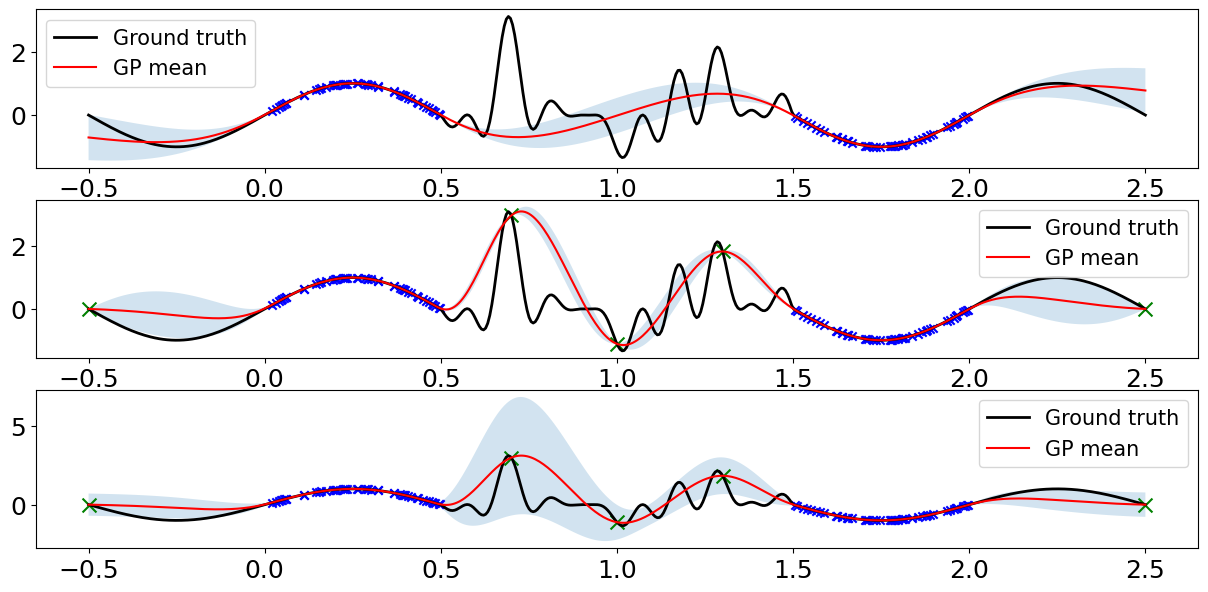

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(15, 7))
axes[0].plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
axes[0].plot(x_test, mean, color='r', linewidth=1.5, label='GP mean')
axes[0].fill_between(x_test.squeeze(), mean - std, mean + std, alpha=.2)
axes[0].scatter(X_train, Y_train, color='b', marker='x')
axes[0].legend(prop={'size': 15})
axes[0].tick_params(axis='both', which='major', labelsize=18)

axes[1].plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
axes[1].plot(x_test, mean_new, color='r', linewidth=1.5, label='GP mean')
axes[1].fill_between(x_test.squeeze(), mean_new - std_new, mean_new + std_new, alpha=.2)
axes[1].scatter(X_train, Y_train, color='b', marker='x')
axes[1].scatter(ood_x, ood_y, color='g', marker='x', s=100)
axes[1].legend(prop={'size': 15})
axes[1].tick_params(axis='both', which='major', labelsize=18)

axes[2].plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
axes[2].plot(x_test, mean_new, color='r', linewidth=1.5, label='GP mean')
axes[2].fill_between(x_test.squeeze(), mean_new - mean_e.sqrt(), mean_new + mean_e.sqrt(), alpha=.2)
axes[2].scatter(X_train, Y_train, color='b', marker='x')
axes[2].scatter(ood_x, ood_y, color='g', marker='x', s=100)
axes[2].legend(prop={'size': 15})
axes[2].tick_params(axis='both', which='major', labelsize=18)

/var/folders/48/q7zy1z255gbbzwwgxlsz6s980000gn/T/ipykernel_74610/3014644723.py:31: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../figures/GP_bad_DEUP_good.png')
/Users/salem/opt/miniconda3/envs/deup/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


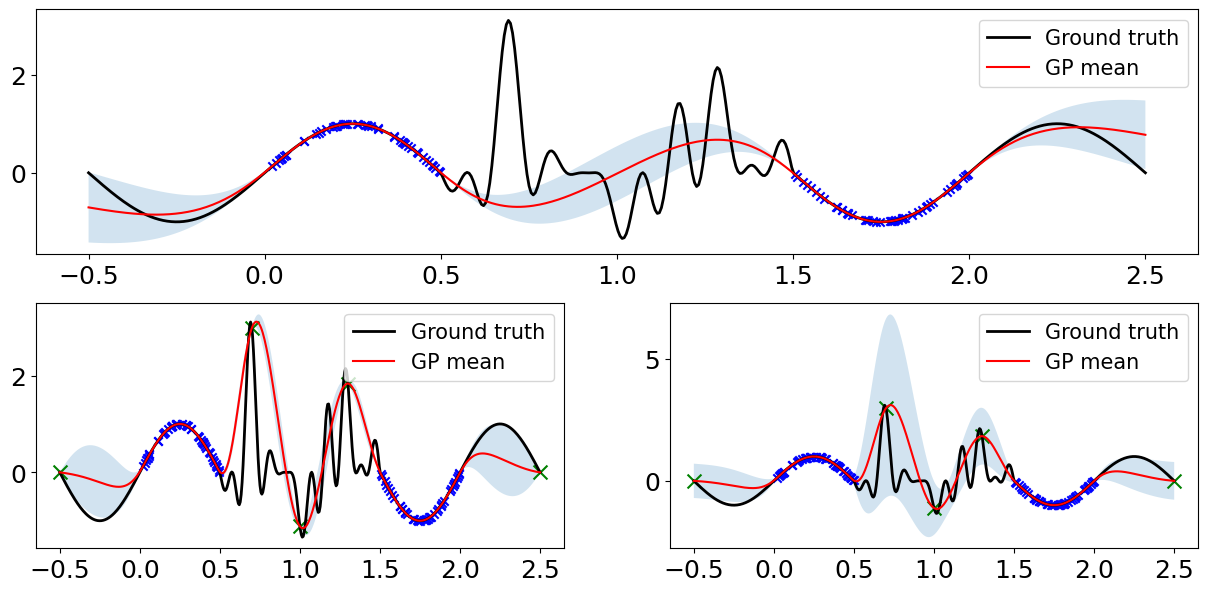

In [59]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(15, 7))
gs = GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

ax0.plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
ax0.plot(x_test, mean, color='r', linewidth=1.5, label='GP mean')
ax0.fill_between(x_test.squeeze(), mean - std, mean + std, alpha=.2)
ax0.scatter(X_train, Y_train, color='b', marker='x')
ax0.legend(prop={'size': 15})
ax0.tick_params(axis='both', which='major', labelsize=18)

ax1.plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
ax1.plot(x_test, mean_new, color='r', linewidth=1.5, label='GP mean')
ax1.fill_between(x_test.squeeze(), mean_new - std_new, mean_new + std_new, alpha=.2)
ax1.scatter(X_train, Y_train, color='b', marker='x')
ax1.scatter(ood_x, ood_y, color='g', marker='x', s=100)
ax1.legend(prop={'size': 15})
ax1.tick_params(axis='both', which='major', labelsize=18)

ax2.plot(x_test, y_test, color='k', linewidth=2, label='Ground truth')
ax2.plot(x_test, mean_new, color='r', linewidth=1.5, label='GP mean')
ax2.fill_between(x_test.squeeze(), mean_new - mean_e.sqrt(), mean_new + mean_e.sqrt(), alpha=.2)
ax2.scatter(X_train, Y_train, color='b', marker='x')
ax2.scatter(ood_x, ood_y, color='g', marker='x', s=100)
ax2.legend(prop={'size': 15})
ax2.tick_params(axis='both', which='major', labelsize=18)

plt.savefig('../figures/GP_bad_DEUP_good.png')
